<a href="https://colab.research.google.com/github/ytepetam/yt.datajarlabs/blob/master/SharePricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(4617, 50, 5)
(513, 50, 5)
Train on 4155 samples, validate on 462 samples
Epoch 1/50
4155/4155 [==============================] - 4s 1ms/step - loss: 0.3712 - val_loss: 8.1515e-05
Epoch 2/50
4155/4155 [==============================] - 4s 896us/step - loss: 0.0070 - val_loss: 3.2921e-04
Epoch 3/50
4155/4155 [==============================] - 4s 891us/step - loss: 0.0056 - val_loss: 1.1293e-04
Epoch 4/50
4155/4155 [==============================] - 4s 904us/step - loss: 0.0046 - val_loss: 5.0499e-05
Epoch 5/50
4155/4155 [==============================] - 4s 894us/step - loss: 0.0038 - val_loss: 6.6956e-05
Epoch 6/50
4155/4155 [==============================] - 4s 885us/step - loss: 0.0032 - val_loss: 1.4263e-04
Epoch 7/50
4155/4155 [==============================] - 4s 899us/step - loss: 0.0029 - val_loss: 7.9690e-05
Epoch 8/50
4155/4155 [==============================] - 4s 899us/step - loss: 0.0025 - val_loss: 6.2588e-05
Epoch 9/50
4155/4155 [==============================] - 4s 897us

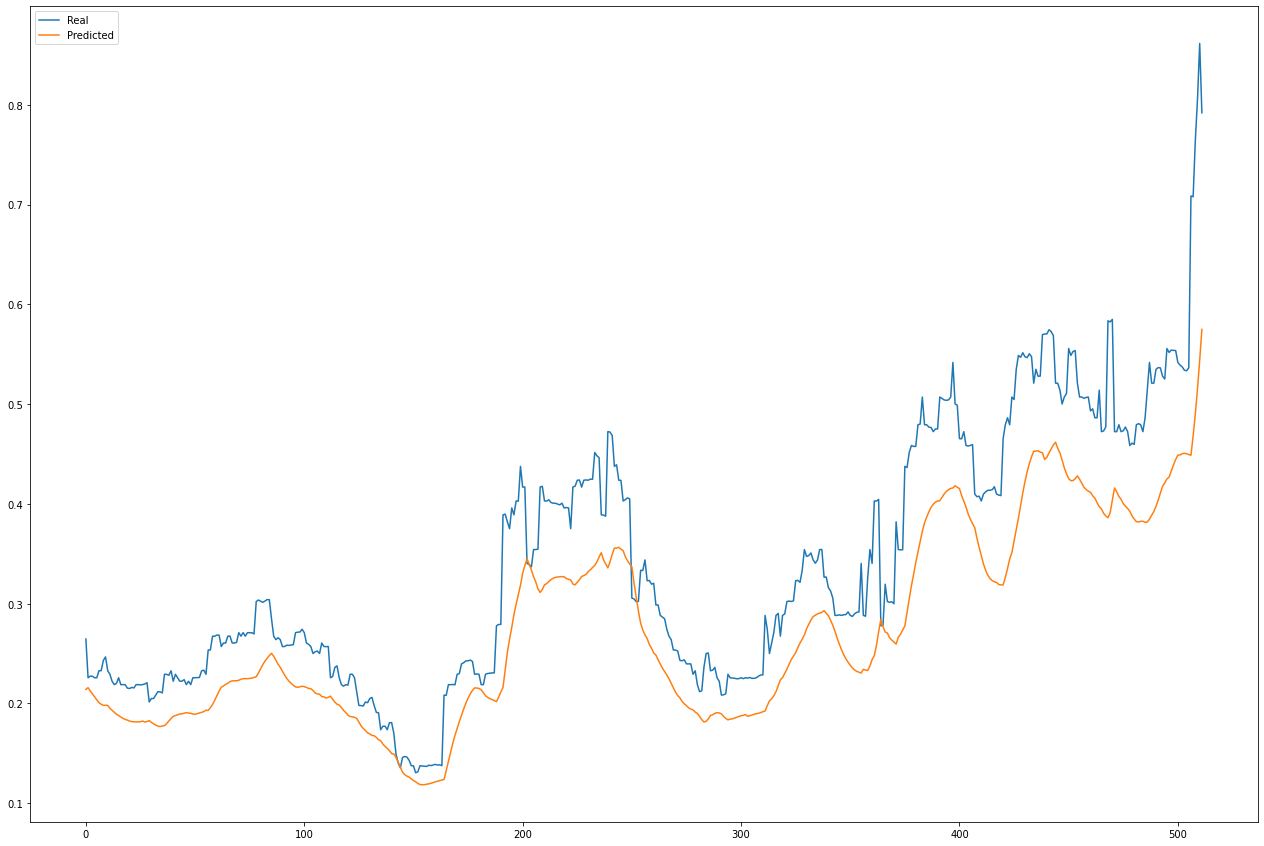

In [4]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
import numpy as np
np.random.seed(4)
#from tensorflow import set_random_seed
#set_random_seed(4)
from util import csv_to_dataset, history_points


# dataset

ohlcv_histories, technical_indicators, next_day_open_values, unscaled_y, y_normaliser = csv_to_dataset('HEKTS.IS_daily.csv')

test_split = 0.9
n = int(ohlcv_histories.shape[0] * test_split)

ohlcv_train = ohlcv_histories[:n]
tech_ind_train = technical_indicators[:n]
y_train = next_day_open_values[:n]

ohlcv_test = ohlcv_histories[n:]
tech_ind_test = technical_indicators[n:]
y_test = next_day_open_values[n:]

unscaled_y_test = unscaled_y[n:]

print(ohlcv_train.shape)
print(ohlcv_test.shape)


# model architecture

# define two sets of inputs
lstm_input = Input(shape=(history_points, 5), name='lstm_input')
dense_input = Input(shape=(technical_indicators.shape[1],), name='tech_input')

# the first branch operates on the first input
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
lstm_branch = Model(inputs=lstm_input, outputs=x)

# the second branch opreates on the second input
y = Dense(20, name='tech_dense_0')(dense_input)
y = Activation("relu", name='tech_relu_0')(y)
y = Dropout(0.2, name='tech_dropout_0')(y)
technical_indicators_branch = Model(inputs=dense_input, outputs=y)

# combine the output of the two branches
combined = concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')

z = Dense(64, activation="sigmoid", name='dense_pooling')(combined)
z = Dense(1, activation="linear", name='dense_out')(z)

# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)
adam = optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mse')
model.fit(x=[ohlcv_train, tech_ind_train], y=y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)


# evaluation

y_test_predicted = model.predict([ohlcv_test, tech_ind_test])
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
y_predicted = model.predict([ohlcv_histories, technical_indicators])
y_predicted = y_normaliser.inverse_transform(y_predicted)
assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

import matplotlib.pyplot as plt

plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

# real = plt.plot(unscaled_y[start:end], label='real')
# pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])

plt.show()

from datetime import datetime
model.save(f'technical_model.h5')

buys: 0
sells: 12
earnings: $0


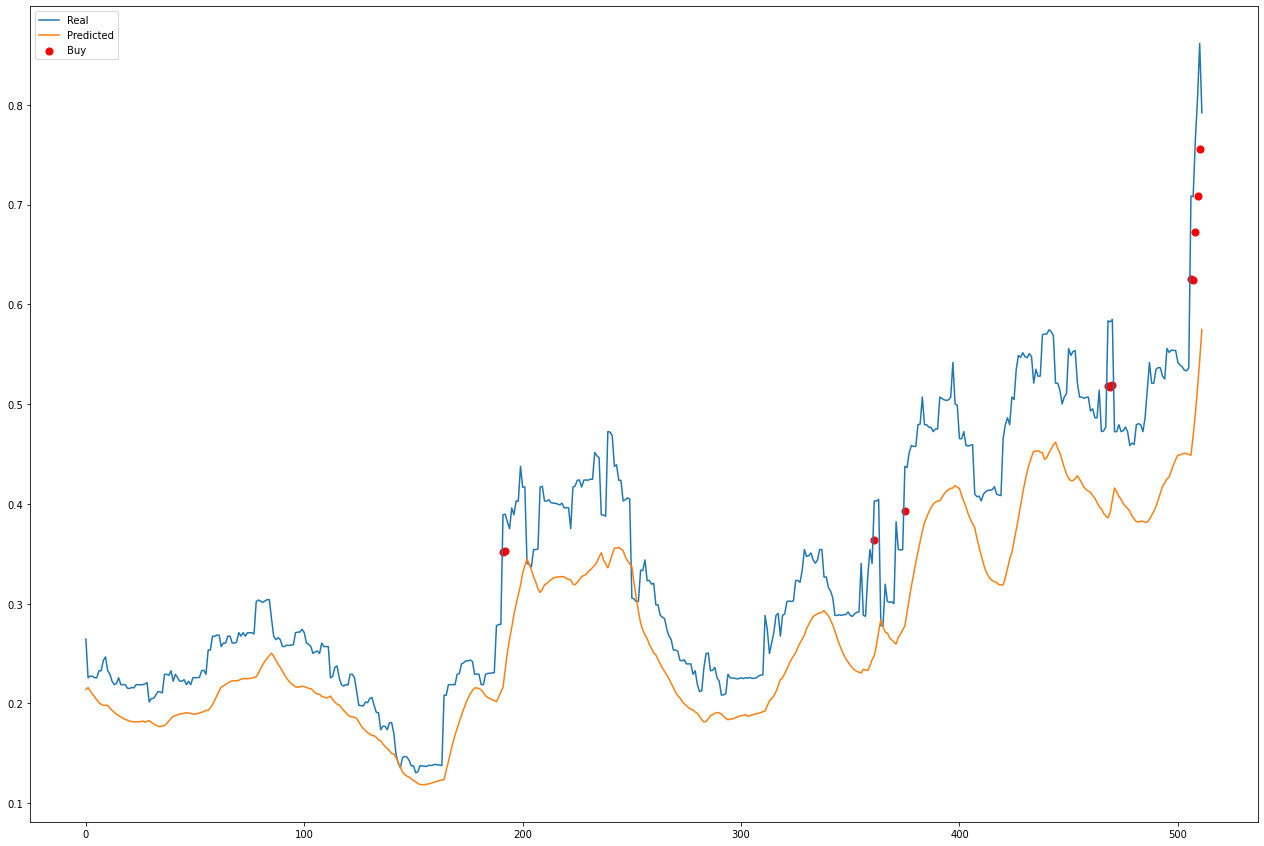

In [6]:
import numpy as np
from keras.models import load_model
from util import csv_to_dataset, history_points

model = load_model('technical_model.h5')

ohlcv_histories, technical_indicators, next_day_open_values, unscaled_y, y_normaliser = csv_to_dataset('HEKTS.IS_daily.csv')

test_split = 0.9
n = int(ohlcv_histories.shape[0] * test_split)

ohlcv_train = ohlcv_histories[:n]
tech_ind_train = technical_indicators[:n]
y_train = next_day_open_values[:n]

ohlcv_test = ohlcv_histories[n:]
tech_ind_test = technical_indicators[n:]
y_test = next_day_open_values[n:]

unscaled_y_test = unscaled_y[n:]

y_test_predicted = model.predict([ohlcv_test, tech_ind_test])
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)

buys = []
sells = []
thresh = 0.1

start = 0
end = -1

x = -1
for ohlcv, ind in zip(ohlcv_test[start: end], tech_ind_test[start: end]):
    normalised_price_today = ohlcv[-1][0]
    normalised_price_today = np.array([[normalised_price_today]])
    price_today = y_normaliser.inverse_transform(normalised_price_today)
    predicted_price_tomorrow = np.squeeze(y_normaliser.inverse_transform(model.predict([[ohlcv], [ind]])))
    delta = predicted_price_tomorrow - price_today
    if delta > thresh:
        buys.append((x, price_today[0][0]))
    elif delta < -thresh:
        sells.append((x, price_today[0][0]))
    x += 1
print(f"buys: {len(buys)}")
print(f"sells: {len(sells)}")


def compute_earnings(buys_, sells_):
    purchase_amt = 10
    stock = 0
    balance = 0
    while len(buys_) > 0 and len(sells_) > 0:
        if buys_[0][0] < sells_[0][0]:
            # time to buy $10 worth of stock
            balance -= purchase_amt
            stock += purchase_amt / buys_[0][1]
            buys_.pop(0)
        else:
            # time to sell all of our stock
            balance += stock * sells_[0][1]
            stock = 0
            sells_.pop(0)
    print(f"earnings: ${balance}")


# we create new lists so we dont modify the original
compute_earnings([b for b in buys], [s for s in sells])

import matplotlib.pyplot as plt

plt.gcf().set_size_inches(22, 15, forward=True)

real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

if len(buys) > 0:
    plt.scatter(list(list(zip(*buys))[0]), list(list(zip(*buys))[1]), c='#00ff00', s=50)
if len(sells) > 0:
    plt.scatter(list(list(zip(*sells))[0]), list(list(zip(*sells))[1]), c='#ff0000', s=50)

# real = plt.plot(unscaled_y[start:end], label='real')
# pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted', 'Buy', 'Sell'])

plt.show()